In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py as h5
import sys
from scipy.stats import binned_statistic
from scipy.stats.mstats import theilslopes
from importlib import reload
from pathlib import Path

sys.path.append('/reg/neh/home4/espov/python/datastorage/')
import datastorage

import ana_fun as ana
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

#matplotlib.rcParams.keys()
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rc('font', size=14)
COLOR = 'grey'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
length = 8
width = 1.5
matplotlib.rcParams['xtick.major.size'] = length
matplotlib.rcParams['ytick.major.size'] = length
matplotlib.rcParams['xtick.major.width'] = width
matplotlib.rcParams['ytick.major.width'] = width

Loading BokehJS ...

### Load data

In [2]:
data = datastorage.read('vesp_run60_anaMPI.h5')
ttdata = datastorage.read('ttdata.h5')

t0 = 51.75
pixel_to_femtosecond = 0.0033444

mask = np.logical_and(~np.isnan(data.sig), ~np.isnan(data.I0))

dl = -(data.dl[mask]-t0)
I0 = data.I0[mask]*1000
I = data.sig[mask]
energy = data.ebeam.photon_energy[mask]
energyL3 = data.ebeam.L3_energy[mask]

dl.shape

(238155,)

### I0 filter

Numbers of shots before I0 filtering: (238155,)
Numbers of shots after I0 filtering: (168869,)


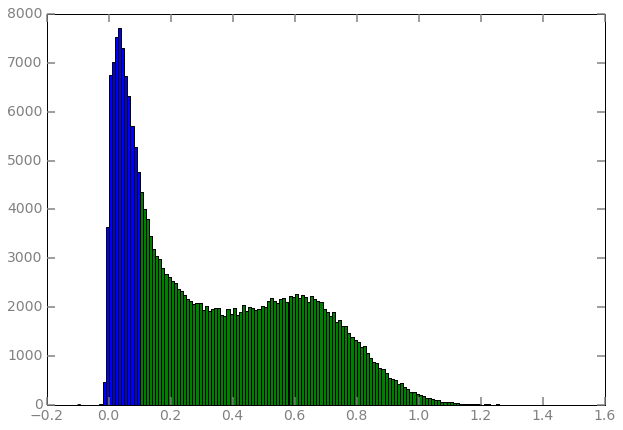

In [3]:
bins=np.arange(-0.1,1.5,0.01)
plt.hist(I0, bins=bins)
print('Numbers of shots before I0 filtering: {}'.format(I0.shape))

I0filt = 0.1
I0mask = I0>I0filt

dl = dl[I0mask]
I0 = I0[I0mask]
I = I[I0mask]
energy = energy[I0mask]
energyL3 = energyL3[I0mask]
print('Numbers of shots after I0 filtering: {}'.format(I0.shape))

plt.hist(I0, bins=bins)
plt.show()

### Get rid of dl position with low shot counts

Numbers of shots before dl filtering: (168869,)
Numbers of shots before dl filtering: (151274,)


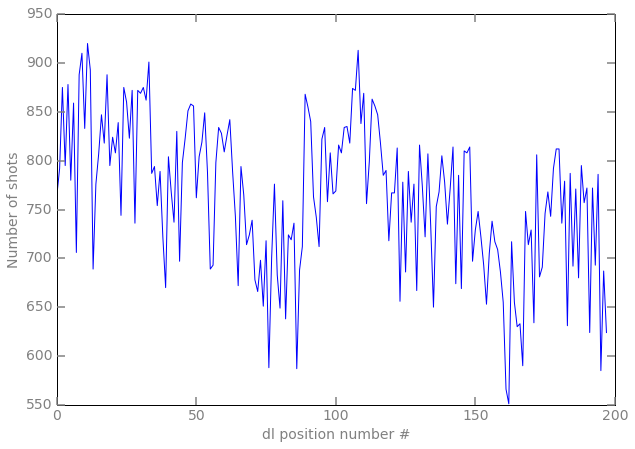

(151274,)

In [4]:
dl_mask = np.zeros(len(dl))
dl_un = np.unique(dl)
for t in dl_un:
    shots = np.sum(t==dl)
    if shots > 500:
        dl_mask = np.logical_or(dl_mask, (t==dl))

print('Numbers of shots before dl filtering: {}'.format(I0.shape))
dl = dl[dl_mask]
I0 = I0[dl_mask]
I = I[dl_mask]
energy = energy[dl_mask]
energyL3 = energyL3[dl_mask]

print('Numbers of shots before dl filtering: {}'.format(I0.shape))

dl_un = np.unique(dl)
shots = []
for t in dl_un:
    shots.append(np.sum(dl==t))

shots = np.asarray(shots)
plt.figure()
plt.plot(shots)
plt.xlabel('dl position number #')
plt.ylabel('Number of shots')
plt.show()

dl.shape

### Time traces

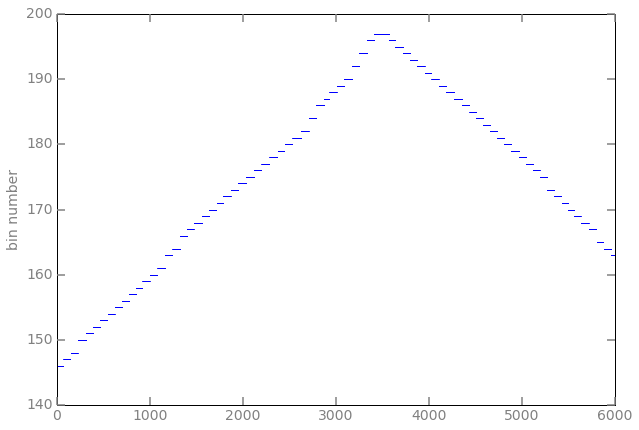

In [5]:
bin_centers = dl_un
binDiff = np.diff(bin_centers)
binDiff = np.append(binDiff, binDiff[-1])
temp = bin_centers+binDiff/2
binEdges = np.append(temp[0]-binDiff[0], temp)
shot_bin = np.digitize(dl, binEdges)
shot_bin = shot_bin-1

plt.figure()
plt.plot(shot_bin[9000:15000], '.', markersize=1)
plt.ylabel('bin number')
plt.show()

#### Apply energy correction for each bin

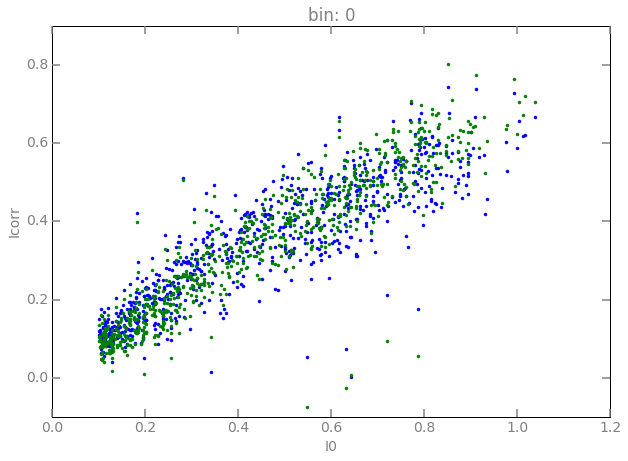

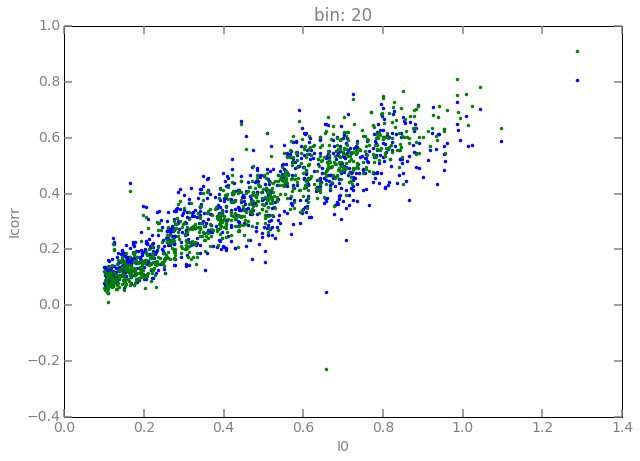

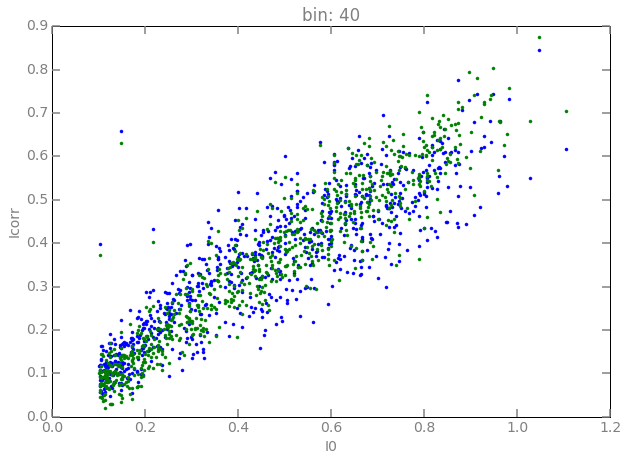

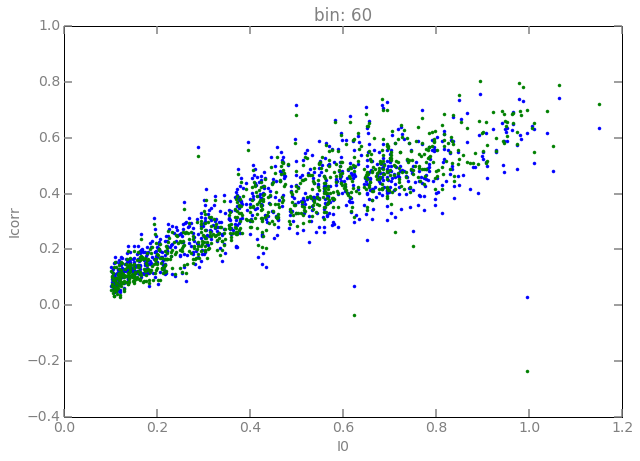

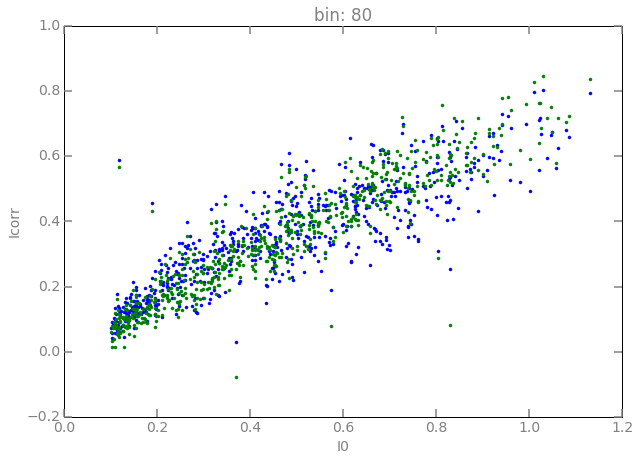

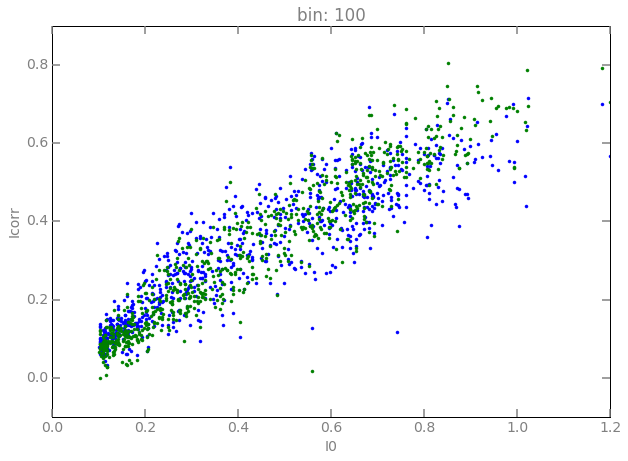

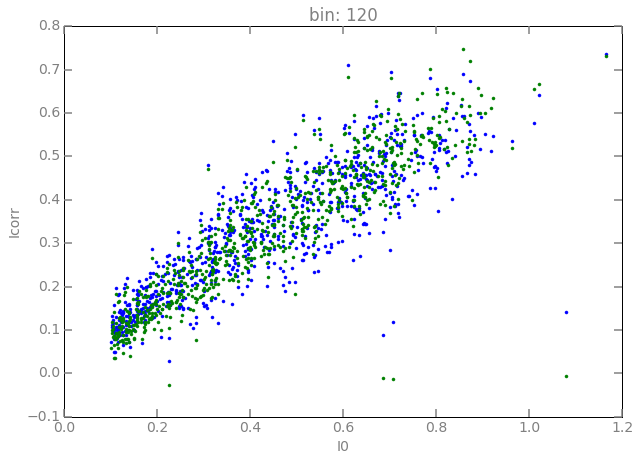

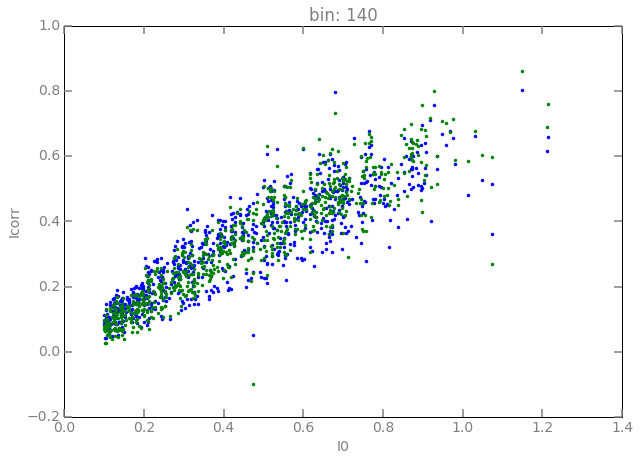

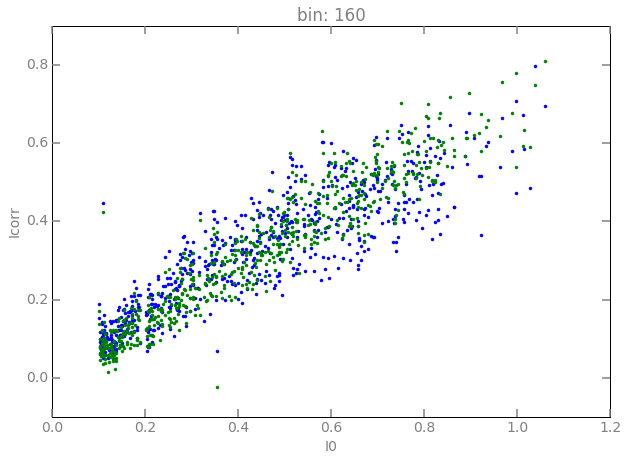

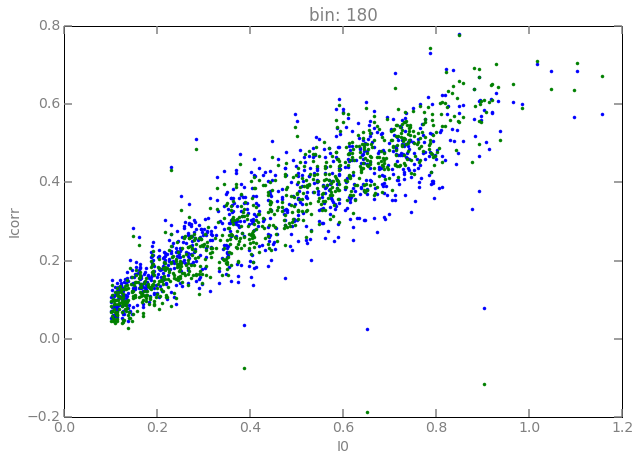

In [6]:
Icorr_bin = []
Icorr_err = []
I_bin = []
I_err = []
for binIdx in np.unique(shot_bin):
    inBin = shot_bin==binIdx
    beta, Xbeta = ana.linearize_energy(I[inBin], I0[inBin], energy[inBin])
    energy_I0_product = (energy[inBin]-np.mean(energy[inBin]))*(I0[inBin]-np.mean(I0[inBin]))
    X = np.array([np.ones(len(I0[inBin])), I0[inBin], energy[inBin], energy_I0_product]).transpose()
    Icorr = I[inBin] - np.matmul(X[:,2:]-np.mean(X,axis=0)[2:], beta[2:])
    Icorr_bin.append(np.mean(Icorr/I0[inBin]))
    Icorr_err.append( np.std(Icorr/I0[inBin])/np.sqrt(np.sum(inBin)) )
    
    I_bin.append(np.mean(I[inBin]/I0[inBin]))
    I_err.append( np.std(I[inBin]/I0[inBin])/np.sqrt(np.sum(inBin)) )
    
    if (binIdx % 20)==0:
        plt.figure()
        plt.title('bin: '+str(binIdx))
        plt.plot(I0[inBin], I[inBin], '.')
        plt.plot(I0[inBin], Icorr, '.')
        plt.xlabel('I0')
        plt.ylabel('Icorr')
        plt.show()
        
    
Icorr_bin = np.asarray(Icorr_bin)
Icorr_err = np.asanyarray(Icorr_err)
I_bin = np.asarray(I_bin)
I_err = np.asanyarray(I_err)

#### Regular binning and global energy correction

In [7]:
beta, Xbeta = ana.linearize_energy(I,I0,energy)
energy_I0_product = (energy-np.mean(energy))*(I0-np.mean(I0))
X = np.array([np.ones(len(I0)), I0, energy, energy_I0_product]).transpose()
Icorr = I - np.matmul(X[:,2:]-np.mean(X,axis=0)[2:], beta[2:])

data_tobin = {
    'dl' : dl/0.15,
    'I0' : I0,
    'I' : I,
    'Inorm' : I/I0,
    'Icorr' : Icorr,
    'IcorrNorm' : Icorr/I0,
    'energy' : energy,
    'energyL3' : energyL3
}

binned_data, bin_edges = ana.binData(data_tobin, statkeys=['I0','I','Inorm','Icorr','IcorrNorm'])

#### Plot the different time traces

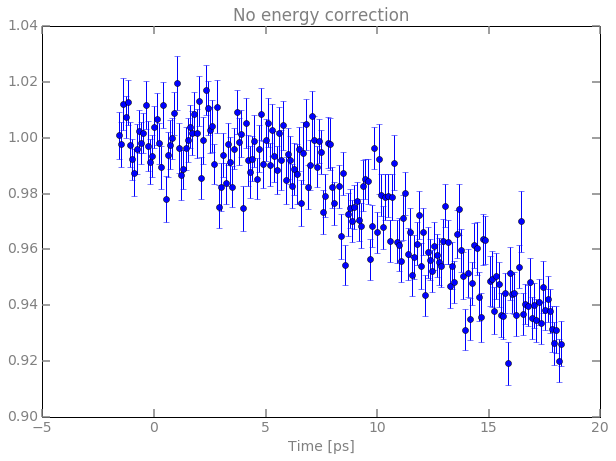

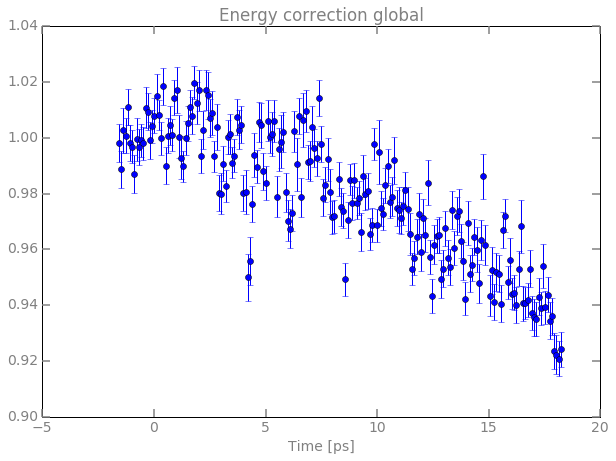

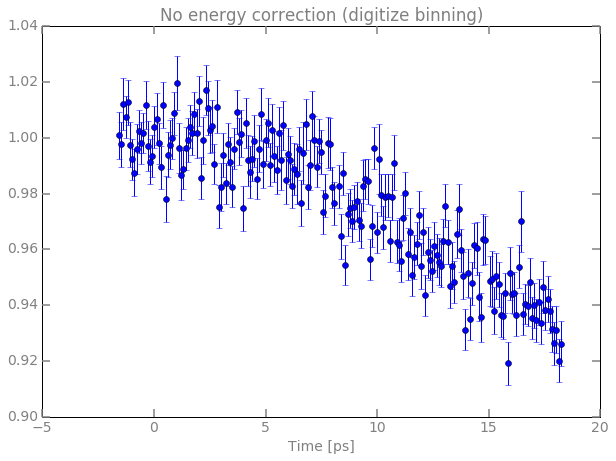

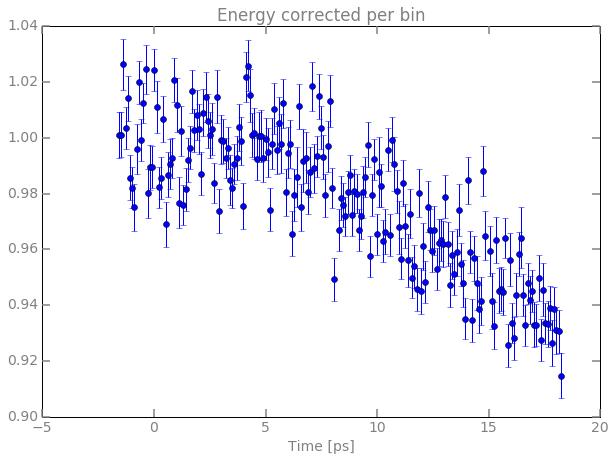

In [8]:
to_plot = 'Inorm'
plt.figure()
plt.title('No energy correction')
plt.errorbar(binned_data['dl'], 
             binned_data[to_plot+'_mean']/np.mean(binned_data[to_plot+'_mean'][binned_data['dl']<0]), 
             binned_data[to_plot+'_std']/np.sqrt(binned_data[to_plot+'_count']), 
             marker='o', linestyle='None')
plt.xlabel('Time [ps]')

to_plot = 'IcorrNorm'
plt.figure()
plt.title('Energy correction global')
plt.errorbar(binned_data['dl'], 
             binned_data[to_plot+'_mean']/np.mean(binned_data[to_plot+'_mean'][binned_data['dl']<0]), 
             binned_data[to_plot+'_std']/np.sqrt(binned_data[to_plot+'_count']), 
             marker='o', linestyle='None')
plt.xlabel('Time [ps]')



plt.figure()
plt.title('No energy correction (digitize binning)')
plt.errorbar(dl_un/0.15, I_bin/np.mean(I_bin[dl_un<0]), I_err, marker='o', linestyle='None')
plt.xlabel('Time [ps]')

plt.figure()
plt.title('Energy corrected per bin')
plt.errorbar(dl_un/0.15, Icorr_bin/np.mean(Icorr_bin[dl_un<0]), I_err, marker='o', linestyle='None')
plt.xlabel('Time [ps]')

plt.show()